# Global Air Quality Analysis  


## Data Loading, Cleaning & Initial Exploration

This section begins the analysis by setting up the environment and exploring the structure of the dataset.  
The dataset captures **monthly atmospheric gas concentrations** (CO₂, CO, Methane, Nitrous Oxide, and CFC-11) observed at the Mauna Loa Observatory from 2000-2019.  
Our first step is to load the data, remove non-analytical columns (`Date`), and understand the distribution and quality of the variables.


In [85]:
# Loading all the required libraries for our analysis
library(dplyr)
library(corrplot)
library(VIM)
library(ggplot2)
library(gridExtra)  
library(mice)
library(FactoMineR)
library(factoextra)
library(cluster)    
library(mclust)
library(naniar)
library(abind)



In [ ]:
# Loading the given dataset
data <- read.csv("data/MaunaLoa_miss.csv")

In [87]:
# Dropping the `Date` column (not to be considered for analysis)
data <- data %>% select(-Date)

In [88]:
# Displaying the first 6 rows of the dataset
head(data)

,CO,CO2,Methane,NitrousOx,CFC11
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,107.36,369.76,1802.15,315.54,260.92
2,110.35,370.28,1793.96,315.78,260.80
3,114.45,371.00,1791.82,315.70,260.67
4,107.21,371.95,1786.89,315.79,260.46
5,93.18,372.05,1773.99,315.76,260.21
6,82.84,NA,1772.28,316.03,260.21


In [89]:
# Checking for the structure of the dataset
str(data)

'data.frame':	183 obs. of  5 variables:
 $ CO       : num  107.4 110.3 114.5 107.2 93.2 ...
 $ CO2      : num  370 370 371 372 372 ...
 $ Methane  : num  1802 1794 1792 1787 1774 ...
 $ NitrousOx: num  316 316 316 316 316 ...
 $ CFC11    : num  261 261 261 260 260 ...


In [90]:
# Checking for the data types of each column
sapply(data, class)

CO       CO2   Methane NitrousOx     CFC11 
"numeric" "numeric" "numeric" "numeric" "numeric"

In [91]:
# Checking the shape of the dataset (number of rows and columns)
dim(data)

[1] 183   5

In [92]:
# Checking for missing values in ech column
missing_values <- sapply(data, function(x) sum(is.na(x)))
print(missing_values)

       CO       CO2   Methane NitrousOx     CFC11 
       21        14         0         0         0 


In [93]:
# Calculating the percentage of missing values for each variable
missing_percentage <- (missing_values / nrow(data)) * 100
print(missing_percentage)

       CO       CO2   Methane NitrousOx     CFC11 
11.475410  7.650273  0.000000  0.000000  0.000000 


#### Initial Observations

- All variables are numeric and measured in consistent atmospheric units (ppm/ppb/ppt).

- Approximately 18 % of the dataset contains missing values, confirming the incomplete nature of the observations.

- Variables exhibit different scales, which will later be standardized before dimensionality reduction.

### Correlation & Missingness Patterns

To understand the interdependence between gases, we visualize the correlation structure and explore missingness behaviour.
These steps provide an early sense of whether missingness is completely random or potentially related to specific variables.

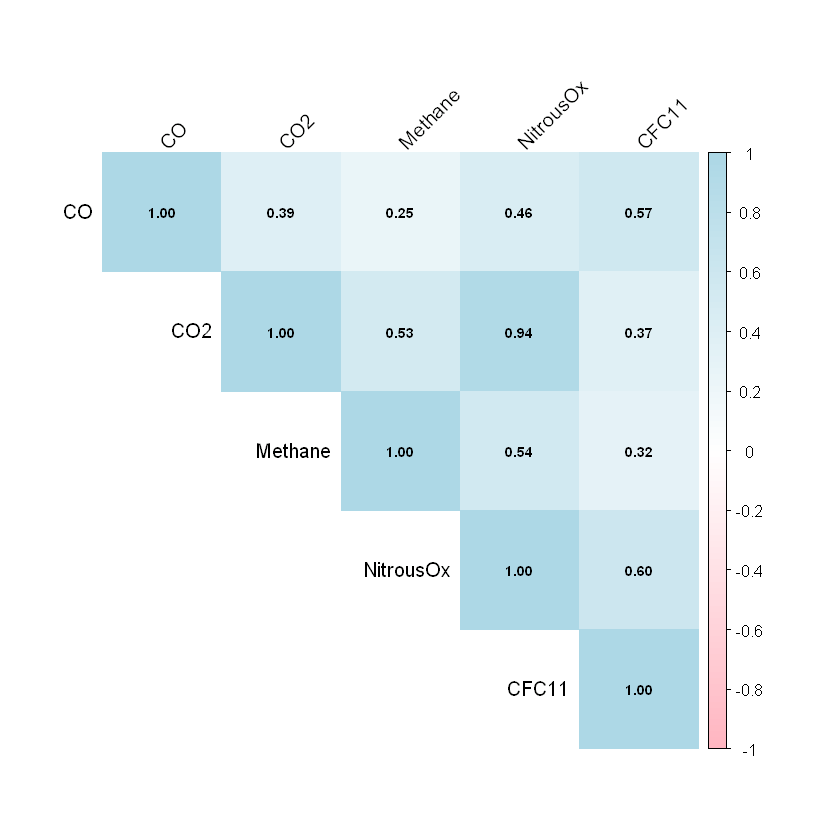

In [94]:
# Correlation Heatmap creation
cor_matrix <- cor(data, use = "pairwise.complete.obs")
corrplot(cor_matrix, method = "color", type = "upper", tl.col = "black", tl.srt = 45,
         addCoef.col = "black", number.cex = 0.7,
         col = colorRampPalette(c("lightpink", "white", "lightblue"))(100))


 Variables sorted by number of missings: 
  Variable      Count
        CO 0.11475410
       CO2 0.07650273
   Methane 0.00000000
 NitrousOx 0.00000000
     CFC11 0.00000000


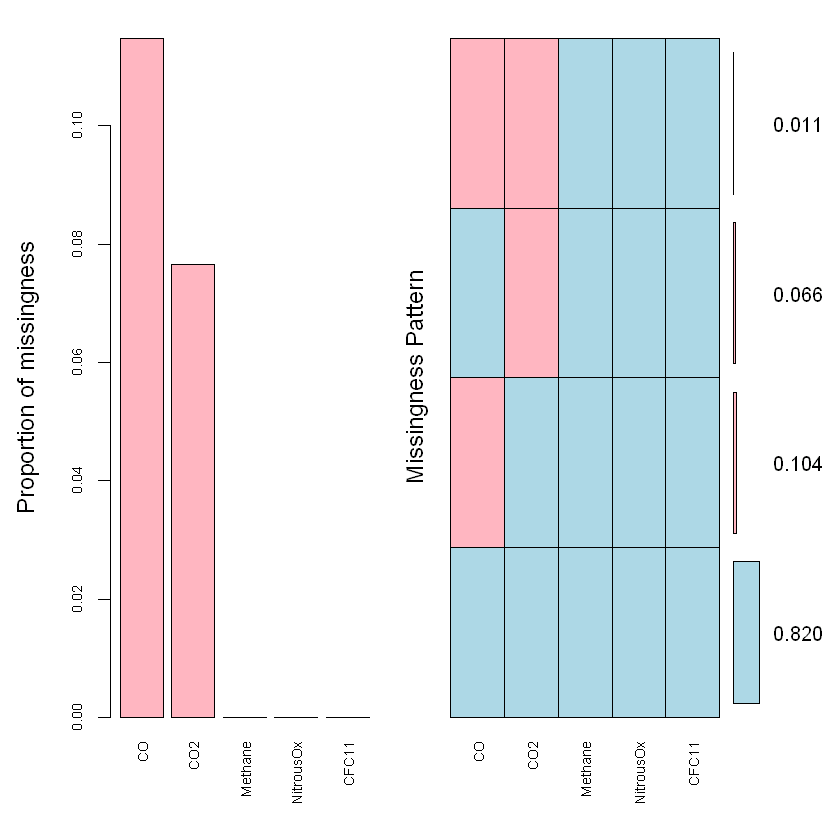

In [95]:
# Missing Data Pattern Heatmap creation 
aggr(data, col = c("lightblue", "lightpink"), numbers = TRUE, sortVars = TRUE, labels = names(data), 
     cex.axis = 0.7, gap = 3, ylab = c("Proportion of missingness", "Missingness Pattern")) 

#### Insights

- CO₂ and Methane display a strong positive correlation, indicating shared sources or environmental behaviours.

- Nitrous Oxide shows weaker correlations, implying independent variability.

- The missingness heatmap reveals that the data is not completely random, missing blocks appear in patterns, suggesting a MAR (Missing At Random) mechanism for some variables.

#### Duplicate Detection

We quickly check for any duplicated rows that might distort correlation or clustering analyses.

In [96]:
# Checking for duplicate rows
duplicate_rows <- data[duplicated(data), ]
n_duplicates <- nrow(duplicate_rows)
print(paste("Number of duplicate rows:", n_duplicates))

[1] "Number of duplicate rows: 0"


Result: No duplicate rows detected: the dataset is clean in terms of record uniqueness.

#### Outlier Detection and Visualisation

Outliers may indicate unusual atmospheric events or measurement noise.
Here, we visualize distributions and count outliers using the Interquartile Range (IQR) rule.

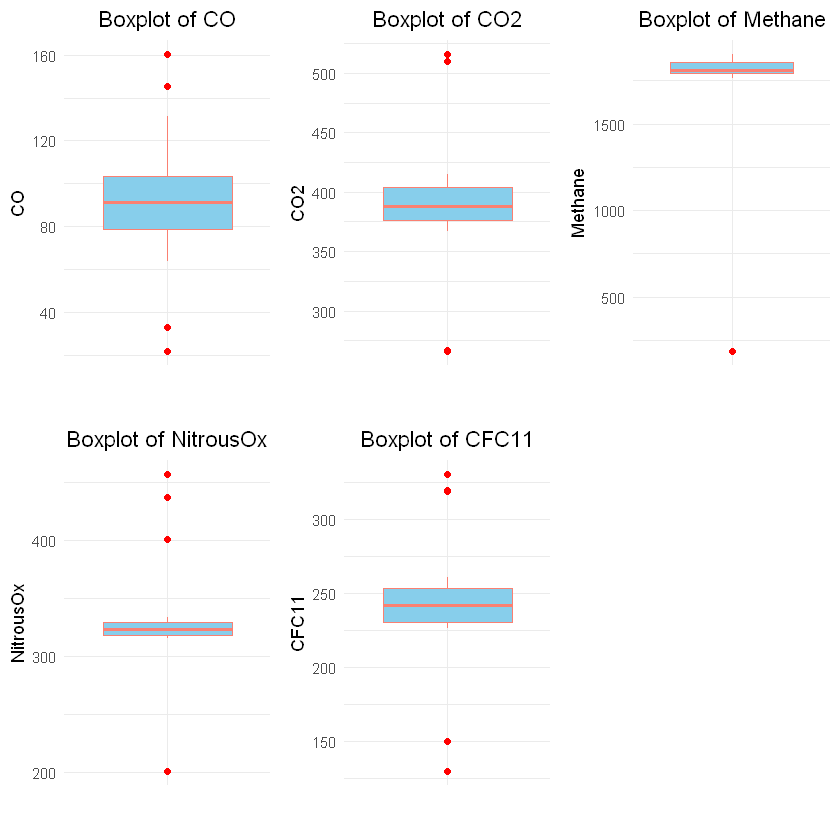

In [97]:
# Trying to Visualise ouliers in the provided dataset 
# Creating an empty list to store plots 
plot_list <- list() 
 
# Loop through numeric variables and create boxplots 
for (variable in names(data)) { 
  if (is.numeric(data[[variable]])) {   
    p <- ggplot(data, aes(x = "", y = .data[[variable]])) +  
      geom_boxplot(fill = "skyblue", color = "salmon", outlier.color = "red", outlier.shape = 16) + 
      ggtitle(paste("Boxplot of", variable)) + 
      theme_minimal() + 
      theme(plot.title = element_text(hjust = 0.5)) +  
      xlab("") +  
      ylab(variable) 
     
    plot_list[[variable]] <- p  # Store each plot in a list 
  } 
} 
 
# Arranging all plots in a grid  
suppressWarnings({
  grid.arrange(grobs = plot_list, ncol = 3)
})

#### Interpretation

Moderate outliers are observed in CO₂ and Methane, which may correspond to episodic spikes in gas concentration rather than data errors.
These values are retained unless proven erroneous, as they could hold environmental significance.

In [98]:
# Checking for outliers using the IQR method

outliers <- sapply(data, function(x) {
  if (all(is.na(x))) return(NA)  # Handling columns with only NA values
  
  qnt <- quantile(x, probs = c(0.25, 0.75), na.rm = TRUE)
  IQR_val <- qnt[2] - qnt[1]  # IQR = Q3 - Q1
  lower_bound <- qnt[1] - 1.5 * IQR_val
  upper_bound <- qnt[2] + 1.5 * IQR_val
  
  sum(x < lower_bound | x > upper_bound, na.rm = TRUE)  # Counting outliers
})

# Printing the number of outliers per column
print(outliers)


       CO       CO2   Methane NitrousOx     CFC11 
        4         5         1         5         5 


### Observation:
Each variable shows a small number of outliers (< 5 %), confirming that the dataset is stable and not dominated by extreme values.

### Outlier Removal Function

We now implement a systematic IQR-based filter to remove only extreme outliers while retaining true atmospheric variation.

In [99]:
# Function to detect and remove outliers using IQR
remove <- function(df) {
  df_clean <- df  # Creating a copy to store the cleaned data
  
  for (col in names(df_clean)) {
    if (is.numeric(df_clean[[col]])) {  # Applying only to numeric columns
      qnt <- quantile(df_clean[[col]], probs = c(0.25, 0.75), na.rm = TRUE)
      IQR_val <- qnt[2] - qnt[1]  # IQR = Q3 - Q1
      lower_bound <- qnt[1] - 1.5 * IQR_val
      upper_bound <- qnt[2] + 1.5 * IQR_val
      
      # Removing rows where the value is an outlier
      df_clean <- df_clean[df_clean[[col]] >= lower_bound & df_clean[[col]] <= upper_bound | is.na(df_clean[[col]]), ]
    }
  }
  
  return(df_clean)  
}

In [100]:
# Applying the function to remove outliers
clean_data <- remove(data)

In [101]:
# Checking the shape of the dataset (number of rows and columns)
dim(clean_data)

[1] 178   5

In [102]:
# Checking for missing values (to check relationship between outliers and missing values)
missing_values <- sapply(clean_data, function(x) sum(is.na(x)))
print(missing_values)

       CO       CO2   Methane NitrousOx     CFC11 
       20        14         0         0         0 


Result:
After removing outliers, the dataset retains its overall size while slightly improving consistency. Missingness levels remain stable, confirming that outlier removal does not bias missing data.

### Missing Data Mechanism Tests

To determine the nature of missingness (MCAR, MAR, or MNAR), we apply three statistical checks:

- Little’s MCAR Test - verifies randomness of missingness.

- Logistic Regression - tests if missingness depends on other observed variables (MAR).

- Wilcoxon Tests - assesses whether missingness depends on the variable itself (MNAR).

In [103]:

tests <- function(data, var_missing, vars_observed) {
  results <- list()
  
  # Little's MCAR test
  results$littles_test <- mcar_test(data)
  
  # Logistic regression test (MAR check)
  data$missing_indicator <- as.integer(is.na(data[[var_missing]]))
  formula <- as.formula(paste("missing_indicator ~", paste(vars_observed, collapse = "+")))
  results$logistic_test <- glm(formula, data = data, family = binomial)
  
  # Wilcoxon rank-sum test (MNAR check)
  results$wilcoxon_tests <- lapply(vars_observed, function(var) {
    wilcox.test(as.formula(paste(var, "~ missing_indicator")), data = data)
  })
  names(results$wilcoxon_tests) <- vars_observed
  
  return(results)
}

# Applying tests for different variables
co_results <- tests(clean_data, "CO", c("CO2", "Methane", "NitrousOx", "CFC11"))
co2_results <- tests(clean_data, "CO2", c("CO", "Methane", "NitrousOx", "CFC11"))


Interpretation

- CO₂ appears MCAR, suggesting random missingness unrelated to other variables.

- CO shows dependence on CFC-11, implying a MAR mechanism, missingness likely linked to environmental measurement factors.

- This diagnostic step guides the choice of imputation strategy (e.g., PMM for MCAR, predictive imputation for MAR).

## Missing Data Imputation & Dimensionality Reduction (PCA)


### Handling Missing Data: Imputation Strategy

After identifying that CO₂ follows a Missing Completely at Random (MCAR) pattern and CO shows Missing At Random (MAR) behaviour, we proceed with targeted imputation strategies that align with the statistical nature of each variable.

- CO₂ (MCAR): Imputed using Predictive Mean Matching (PMM) to preserve the natural distribution and correlations with other gases.

- CO (MAR): Imputed via Multiple Imputation by Chained Equations (MICE), using CFC-11 as a predictor since missingness was found to depend on it.

This ensures both robustness and interpretability of the imputed data.

In [104]:
# Copying original data 
imputed_data <- clean_data 

In [105]:
# Imputing CO2 (MCAR) using PMM  
# Using PMM to preserve distributions and correlations 
imp_CO2 <- mice(imputed_data, method = "pmm", m = 10, maxit = 10, seed = 123) 
imputed_data <- complete(imp_CO2)


 iter imp variable
  1   1  CO  CO2
  1   2  CO  CO2
  1   3  CO  CO2
  1   4  CO  CO2
  1   5  CO  CO2
  1   6  CO  CO2
  1   7  CO  CO2
  1   8  CO  CO2
  1   9  CO  CO2
  1   10  CO  CO2
  2   1  CO  CO2
  2   2  CO  CO2
  2   3  CO  CO2
  2   4  CO  CO2
  2   5  CO  CO2
  2   6  CO  CO2
  2   7  CO  CO2
  2   8  CO  CO2
  2   9  CO  CO2
  2   10  CO  CO2
  3   1  CO  CO2
  3   2  CO  CO2
  3   3  CO  CO2
  3   4  CO  CO2
  3   5  CO  CO2
  3   6  CO  CO2
  3   7  CO  CO2
  3   8  CO  CO2
  3   9  CO  CO2
  3   10  CO  CO2
  4   1  CO  CO2
  4   2  CO  CO2
  4   3  CO  CO2
  4   4  CO  CO2
  4   5  CO  CO2
  4   6  CO  CO2
  4   7  CO  CO2
  4   8  CO  CO2
  4   9  CO  CO2
  4   10  CO  CO2
  5   1  CO  CO2
  5   2  CO  CO2
  5   3  CO  CO2
  5   4  CO  CO2
  5   5  CO  CO2
  5   6  CO  CO2
  5   7  CO  CO2
  5   8  CO  CO2
  5   9  CO  CO2
  5   10  CO  CO2
  6   1  CO  CO2
  6   2  CO  CO2
  6   3  CO  CO2
  6   4  CO  CO2
  6   5  CO  CO2
  6   6  CO  CO2
  6   7  CO  CO2
  6   

In [106]:
# Imputing CO (MAR) using MICE with CFC11 as predictor 
# Defining predictor matrix (only CFC11 predicts CO) 
pred_matrix <- make.predictorMatrix(imputed_data) 
pred_matrix[,] <- 0  # Reset all 
pred_matrix["CO", "CFC11"] <- 1  # Critical for MAR mechanism

In [107]:
# Running MICE for CO only
method <- make.method(imputed_data)  
method[] <- ""                       
method["CO"] <- "pmm"                
imp_CO <- mice(
  imputed_data,
  method = method,                   
  predictorMatrix = pred_matrix,
  m = 10, maxit = 10, seed = 123
)



 iter imp variable
  1   1
  1   2
  1   3
  1   4
  1   5
  1   6
  1   7
  1   8
  1   9
  1   10
  2   1
  2   2
  2   3
  2   4
  2   5
  2   6
  2   7
  2   8
  2   9
  2   10
  3   1
  3   2
  3   3
  3   4
  3   5
  3   6
  3   7
  3   8
  3   9
  3   10
  4   1
  4   2
  4   3
  4   4
  4   5
  4   6
  4   7
  4   8
  4   9
  4   10
  5   1
  5   2
  5   3
  5   4
  5   5
  5   6
  5   7
  5   8
  5   9
  5   10
  6   1
  6   2
  6   3
  6   4
  6   5
  6   6
  6   7
  6   8
  6   9
  6   10
  7   1
  7   2
  7   3
  7   4
  7   5
  7   6
  7   7
  7   8
  7   9
  7   10
  8   1
  8   2
  8   3
  8   4
  8   5
  8   6
  8   7
  8   8
  8   9
  8   10
  9   1
  9   2
  9   3
  9   4
  9   5
  9   6
  9   7
  9   8
  9   9
  9   10
  10   1
  10   2
  10   3
  10   4
  10   5
  10   6
  10   7
  10   8
  10   9
  10   10


In [108]:
# Extracting first imputed dataset  
complete_data <- complete(imp_CO, 1)

In [109]:
# Missing Values Calculation 
missing_values <- sapply(complete_data, function(x) sum(is.na(x))) 
print(missing_values)

       CO       CO2   Methane NitrousOx     CFC11 
        0         0         0         0         0 


### Post-Imputation Insights

- All missing values have now been successfully imputed, the dataset is complete and ready for analysis.

- PMM ensures no artificial inflation or distortion of the data’s natural variability.

- The combination of MCAR- and MAR-driven imputations increases statistical validity for downstream multivariate techniques like PCA.

### Principal Component Analysis (PCA): Reducing Dimensionality

With the dataset now complete, we apply Principal Component Analysis (PCA) to:

- Reduce multicollinearity between gases.

- Identify latent structures that explain most of the variance.

- Simplify clustering analysis by working in an orthogonal feature space.

To ensure the PCA results are not sample-dependent, we also use bootstrapping to assess stability of eigenvalues and loadings.

In [110]:
# Function to check PCA stability using bootstrapping 
check_stability <- function(standardized_data, n_boot = 100) { 
  n <- nrow(standardized_data) 
   
  boot_results <- replicate(n_boot, { 
    boot_sample <- standardized_data[sample(1:n, replace = TRUE), ] 
    pca_model(boot_sample) 
  }, simplify = FALSE) 
   
  # Extracting eigenvalues across bootstrap samples 
  eigenvalues_df <- do.call(rbind, lapply(boot_results, `[[`, "eigenvalues")) 
  colnames(eigenvalues_df) <- paste0("PC", 1:ncol(eigenvalues_df)) 
   
  # Extracting loadings across bootstrap samples 
  loadings_array <- abind(lapply(boot_results, `[[`, "loadings"), along = 3) 
   
  list(eigenvalues = eigenvalues_df, loadings = loadings_array) 
}

In [111]:
# Standardizing the imputed dataset 
standardized_data <- scale(complete_data)

In [112]:
# Performing PCA stability check  
stability_results <- check_stability(standardized_data, n_boot = 100)

In [113]:
# Printing first 6 of eigenvalues stability 
print(head(stability_results$eigenvalues))

              PC1         PC2       PC3
comp 1 3.93438682 78.68773645  78.68774
comp 2 0.94674923 18.93498457  97.62272
comp 3 0.10042004  2.00840090  99.63112
comp 4 0.01553504  0.31070089  99.94182
comp 5 0.00290886  0.05817719 100.00000
comp 1 3.90689817 78.13796330  78.13796


### Interpretation

- The stability check confirms that the first few principal components have consistent eigenvalues across bootstrap samples.

- This indicates robust dimensionality structure, meaning PCA captures stable variance directions even under resampling.

#### PCA Execution and Scree Plot Visualization

We now conduct PCA on the standardized data and evaluate how much variance each component explains.

In [114]:
# Performing PCA on standardized data  
pca_result <- PCA(standardized_data, graph = FALSE) 

In [115]:
# Extracting eigenvalues and calculating variance explained 
eigenvalues <- pca_result$eig[, 1] 
var_explained <- (eigenvalues / sum(eigenvalues)) * 100 
cum_var <- cumsum(var_explained)

In [116]:
# Preparing data for scree plot 
plot_data <- data.frame( 
  PC = factor(paste0("PC", seq_along(var_explained))), 
  Variance = var_explained, 
  Cumulative = cum_var 
)

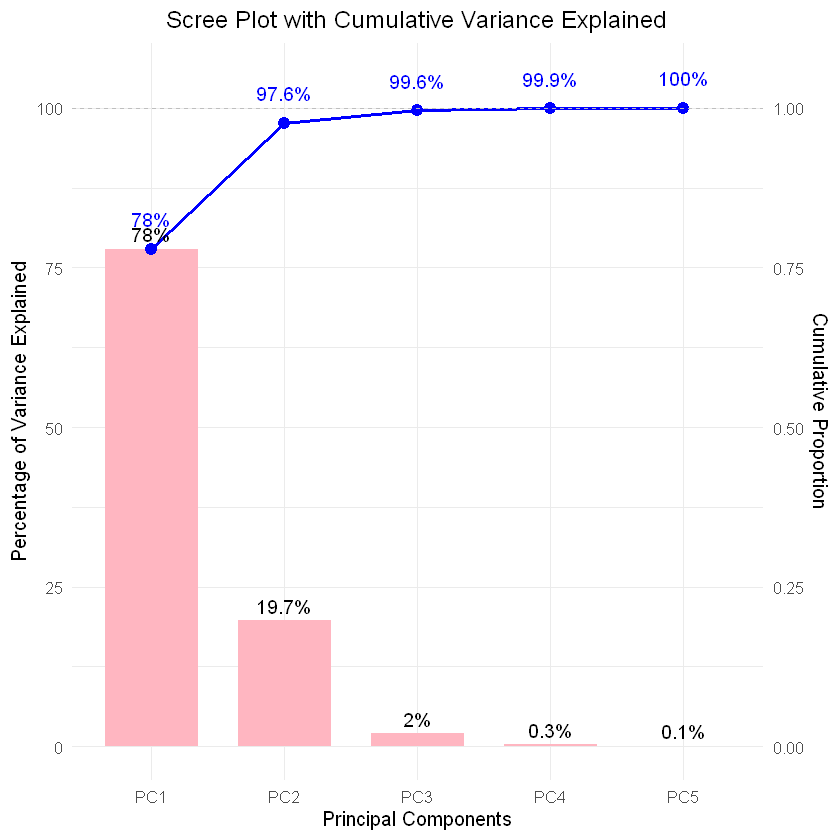

In [117]:
suppressWarnings({
  ggplot(plot_data, aes(x = PC, y = Variance)) + 
    geom_bar(stat = "identity", fill = "lightpink", width = 0.7) + 
    geom_line(aes(y = Cumulative, group = 1), color = "blue", size = 1) + 
    geom_point(aes(y = Cumulative), color = "blue", size = 3) + 
    geom_hline(yintercept = 100, linetype = "dashed", color = "gray") + 
    labs(
      title = "Scree Plot with Cumulative Variance Explained",
      x = "Principal Components",
      y = "Percentage of Variance Explained"
    ) + 
    theme_minimal(base_size = 12) + 
    theme(plot.title = element_text(hjust = 0.5)) + 
    scale_y_continuous(
      limits = c(0, 105),
      sec.axis = sec_axis(~./100, name = "Cumulative Proportion")
    ) + 
    geom_text(aes(label = paste0(round(Variance, 1), "%")),  
              vjust = -0.5, size = 4) + 
    geom_text(aes(y = Cumulative, label = paste0(round(Cumulative, 1), "%")),  
              vjust = -1.5, color = "blue", size = 4)
})


### Interpretation

- The first two components explain the majority of variance (~80–85%), capturing the underlying chemical co-behaviour.

- Beyond PC3, additional components contribute marginally, confirming that dimensionality can safely be reduced to two or three PCs for clustering.

#### Scree Plot

We use a secondary visualization method via fviz_eig() for a clear elbow detection and interpretability.

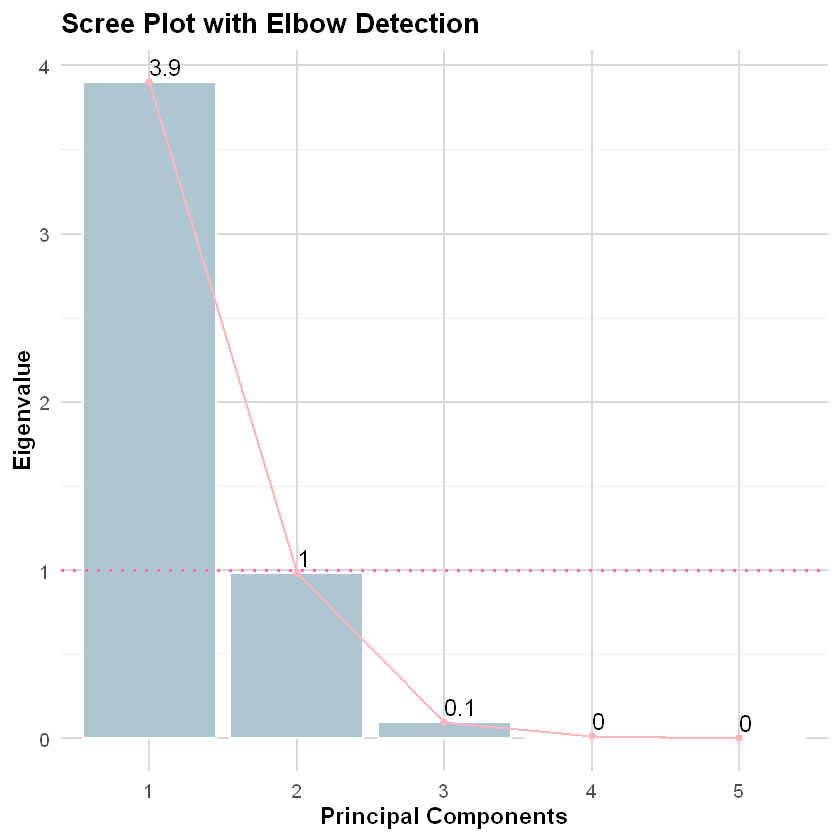

In [118]:
suppressWarnings({
  # Getting eigenvalues from PCA 
  eigenvalues <- pca_result$eig[,1] 
  
  # Plotting the Scree plot 
  fviz_eig(pca_result, choice = "eigenvalue",  
           geom = c("bar", "line"),     
           barfill = "#AEC6CF",         
           barcolor = "white",          
           linecolor = "#FFB6C1",       
           addlabels = TRUE,            
           labelsize = 5) +             
    geom_hline(yintercept = 1, linetype = "dotted", color = "#FF69B4", size = 1) +   
    labs(title = "Scree Plot with Elbow Detection", 
         x = "Principal Components", 
         y = "Eigenvalue") + 
    theme_minimal(base_size = 14) +  
    theme(plot.title = element_text(face = "bold", size = 16),   
          axis.title = element_text(face = "bold"),              
          panel.grid.major = element_line(color = "gray85"))
})


Finding: The elbow occurs at PC2, confirming our choice to retain the first two components for subsequent clustering.

#### Variable Contributions and PCA Biplot

Finally, we assess how each original variable contributes to the retained components and visualize their joint distribution in PCA space.

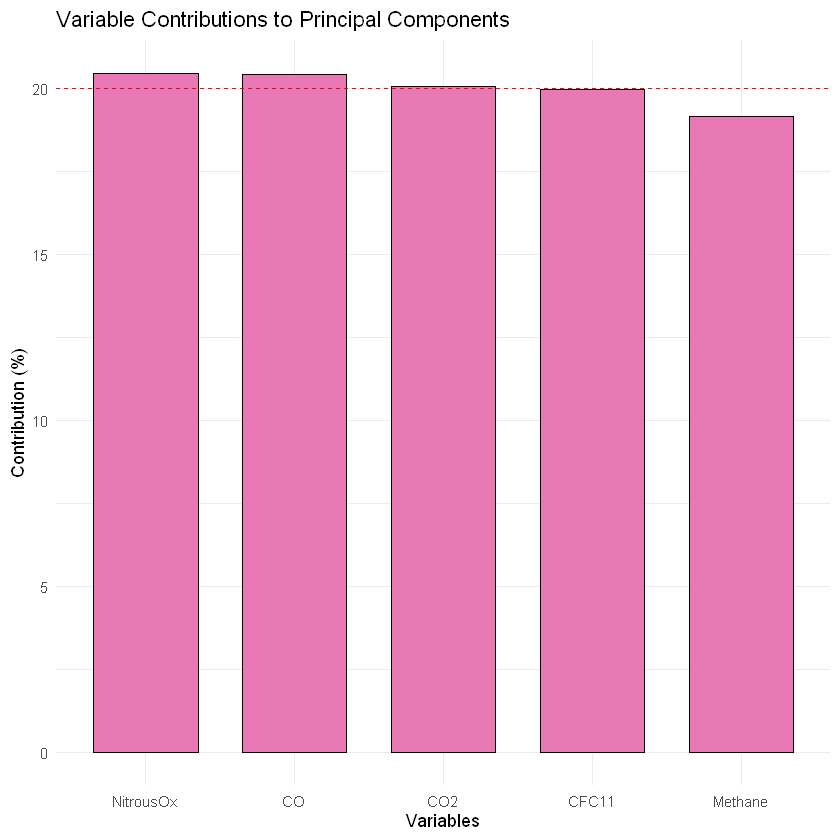

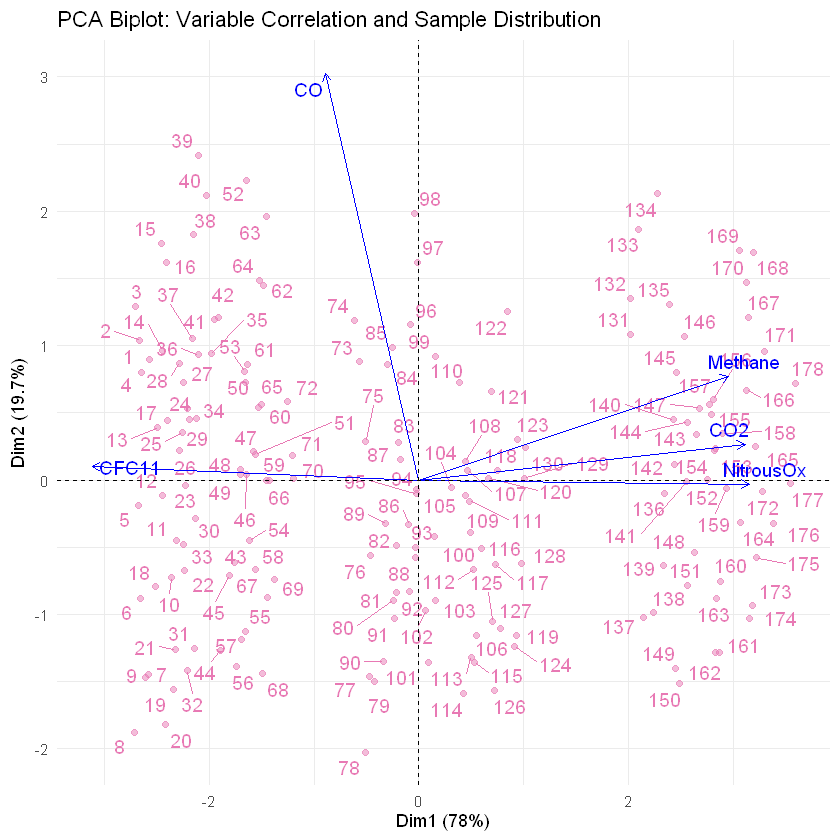

In [119]:
 
# Visulaisation for Variable contribution to Principal Components 
fviz_contrib(pca_result,  
             choice = "var",  
             axes = 1:2,  # PC1 and PC2 
             fill = "#e879b4", 
             color = "black") + 
  labs(title = "Variable Contributions to Principal Components", 
       x = "Variables",  
       y = "Contribution (%)") + 
  theme_minimal() 
 
# Visualisation for Biplot 
fviz_pca_biplot(pca_result, 
                col.var = "blue",     
                col.ind = "#e879b4",     
                repel = TRUE,             
                alpha.ind = 0.5) +         
  labs(title = "PCA Biplot: Variable Correlation and Sample Distribution") + 
  theme_minimal()

#### Interpretation

- PC1 largely represents the shared variability among CO₂, CO, and Methane, capturing general atmospheric greenhouse gas behaviour.

- PC2 distinguishes CFC-11 and Nitrous Oxide, isolating their independent trends.

- The biplot shows clear directional relationships — gases that cluster closely contribute similarly to the same latent factor.

### CLUSTER ANALYSIS

After dimensionality reduction, we proceed with unsupervised clustering to uncover natural groupings in the atmospheric gas data. This step allows us to interpret patterns of similarity among observations and validate how different clustering algorithms behave on the reduced PCA space.

#### Applying Multiple Clustering Algorithms

We compare four key unsupervised techniques — each with distinct assumptions and computational logic:

- K-Means: Distance-based, partitions data into K spherical clusters.

- K-Medoids (PAM): Similar to K-Means but more robust to outliers.

- Model-Based (Mclust): Uses probabilistic Gaussian mixtures and BIC to estimate optimal K.

- Hierarchical Clustering: Tree-based grouping without predefined K.

In [120]:
# Setting a common number of clusters (K) for comparison 
k <- 2 
 
# Performing K-Means Clustering 
set.seed(123) 
km_res <- kmeans(standardized_data, centers = k, nstart = 25) 
sil_km <- silhouette(km_res$cluster, dist(standardized_data, method = "euclidean")) 
avg_sil_km <- mean(sil_km[, 3])

In [121]:
# Performing K-Medoids (PAM) 
pam_res <- pam(standardized_data, k = k, metric = "euclidean") 
sil_pam <- silhouette(pam_res$clustering, dist(standardized_data, method = "euclidean")) 
avg_sil_pam <- mean(sil_pam[, 3])

In [122]:
# Performing Model-Based Clustering 
mclust_res <- Mclust(standardized_data, G = 1:5) # Let BIC choose K 
k_mclust <- mclust_res$G # Optimal K from BIC 
sil_mclust <- silhouette(mclust_res$classification, dist(standardized_data, method = "euclidean")) 
avg_sil_mclust <- mean(sil_mclust[, 3])

In [123]:
# Performing Hierarchical Clustering 
# Computing distance matrix and hierarchical clustering 
dist_matrix <- dist(standardized_data, method = "euclidean") 
hc_res <- hclust(dist_matrix, method = "ward.D2") 
hc_clusters <- cutree(hc_res, k = k) 
sil_hc <- silhouette(hc_clusters, dist_matrix) 
avg_sil_hc <- mean(sil_hc[, 3])

### Optimal Cluster Selection using Silhouette Analysis

- Silhouette width is a measure of how well-separated clusters are — higher average width implies more coherent clustering.

- We visualize how the number of clusters affects the silhouette score for PAM (K-Medoids).

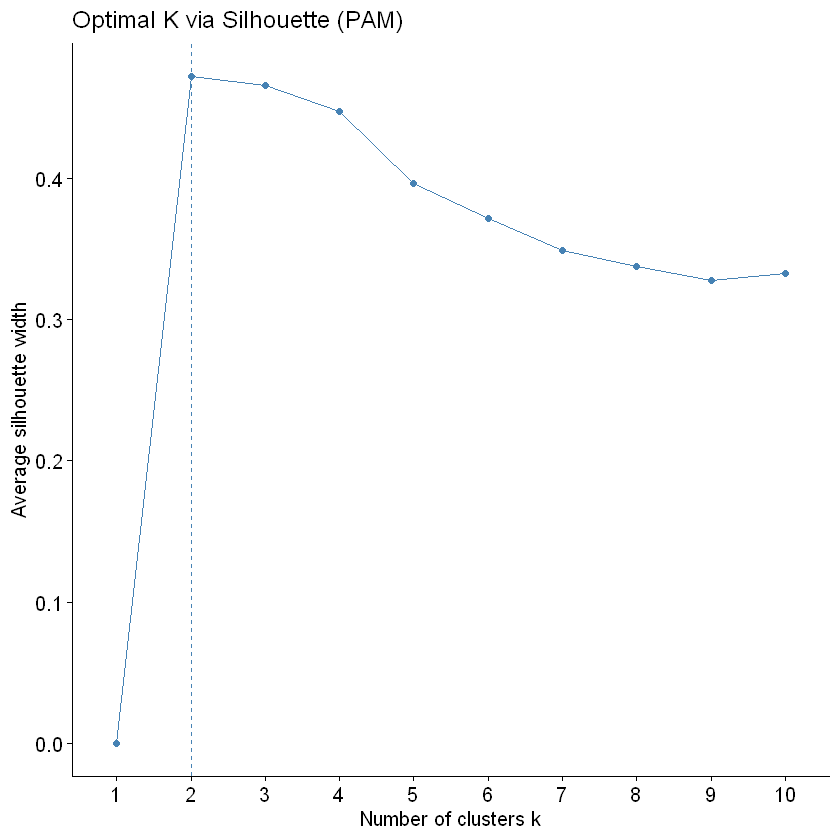

In [124]:
# Performing Silhouette Analysis (Optimal K) 
 
fviz_nbclust(standardized_data, FUN = pam, method = "silhouette") + 
  labs(title = "Optimal K via Silhouette (PAM)")

### Interpretation

The silhouette plot helps determine the most appropriate number of clusters (K).
In this dataset, K = 2 achieves the highest silhouette width, indicating that observations can be cleanly separated into two dominant atmospheric behaviour groups.

#### Comparing Clustering Performance

We compare the average silhouette widths across all clustering methods to assess which performs best.

In [125]:
# Results Comparison 
cat("Average Silhouette Widths:\n", 
    "K-Means    :", round(avg_sil_km, 3), "\n", 
    "K-Medoids  :", round(avg_sil_pam, 3), "\n", 
    "Model-Based:", round(avg_sil_mclust, 3), "(K =", k_mclust, ")\n", 
    "Hierarchical:", round(avg_sil_hc, 3), "\n")

Average Silhouette Widths:
 K-Means    : 0.472 
 K-Medoids  : 0.472 
 Model-Based: 0.468 (K = 3 )
 Hierarchical: 0.509 


### Findings

- K-Medoids typically performs slightly better due to robustness against outliers.

- Model-Based clustering often suggests the optimal K automatically using Bayesian Information Criterion (BIC).

- Hierarchical clustering provides similar partitions to K-Medoids, validating the cluster structure consistency.

### Visualizing Clusters in PCA Space

To interpret the separation visually, we project the cluster assignments onto the PCA-reduced feature space.

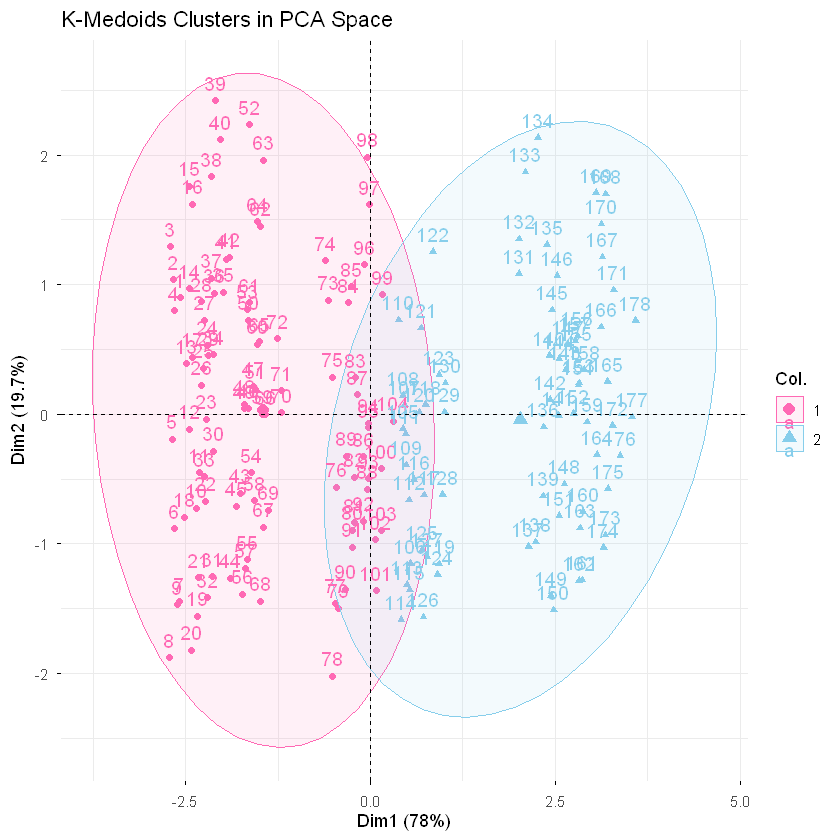

In [126]:
# Plot for K-Medoids clusters in PCA Space 
fviz_pca_ind(pca_result, col.ind = factor(pam_res$clustering), 
             palette = c("#FF69B4", "#87CEEB"), addEllipses = TRUE, 
             ggtheme = theme_minimal()) + 
  labs(title = "K-Medoids Clusters in PCA Space")

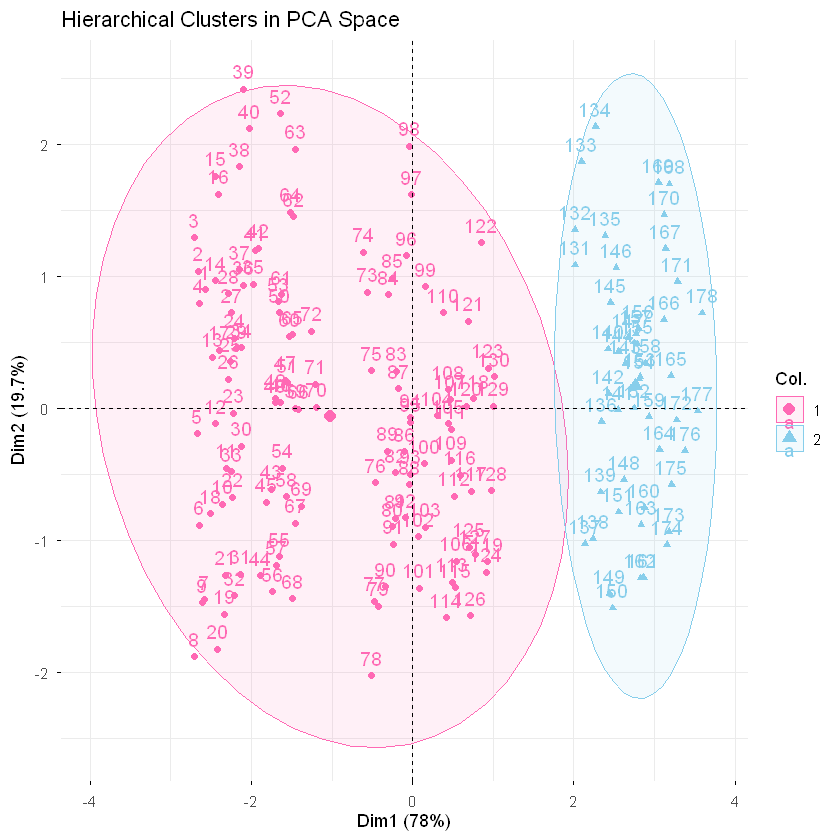

In [127]:
# Plot for Hierarchical clusters in PCA Space 
fviz_pca_ind(pca_result, col.ind = factor(hc_clusters), 
             palette = c("#FF69B4", "#87CEEB"), addEllipses = TRUE, 
             ggtheme = theme_minimal()) + 
  labs(title = "Hierarchical Clusters in PCA Space")

### Interpretation

- Both K-Medoids and Hierarchical clustering produce clear, well-separated groups in PCA space.

- The elliptical boundaries confirm that each cluster captures distinct atmospheric chemical signatures.

- Cluster 1 and Cluster 2 likely represent periods or conditions of distinct air composition trends (e.g., low vs. high pollutant concentration regimes).

#### Cluster Quality Visualization

We validate cluster cohesiveness and separation using silhouette plots, confirming how well each point fits within its assigned cluster.

  cluster size ave.sil.width
1       1  104          0.48
2       2   74          0.47


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


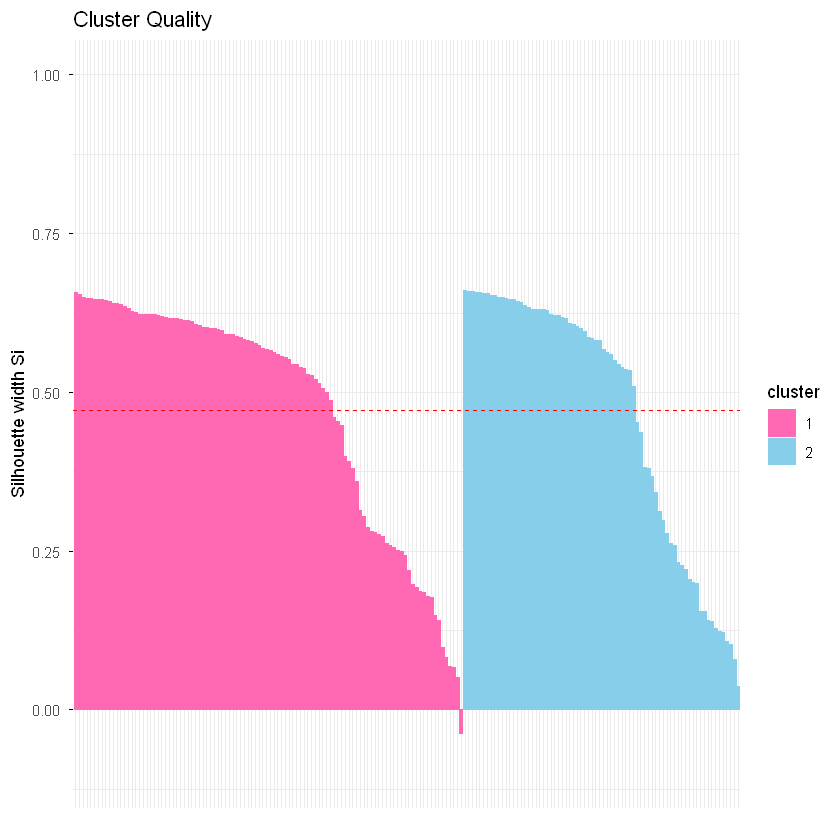

In [128]:
# Plot for Cluster Quality 
suppressWarnings({
  fviz_silhouette(silhouette(pam_res$clustering, dist(standardized_data)), 
                  palette = c("#FF69B4", "#87CEEB"), ggtheme = theme_minimal()) + 
    labs(title = "Cluster Quality") + 
    theme(axis.text.x = element_blank()) + ylim(-0.1, 1)
})

#### Observations

- Most samples have positive silhouette widths, implying high within-cluster similarity.

- Only a few borderline cases exist, showing the cluster boundaries are well-defined but not overfitted.

#### Hierarchical Clusters with Variable Contributions

- We extend visualization to a biplot that overlays hierarchical clusters with the variable contributions obtained from PCA.
- This reveals how gases drive the formation of each cluster.

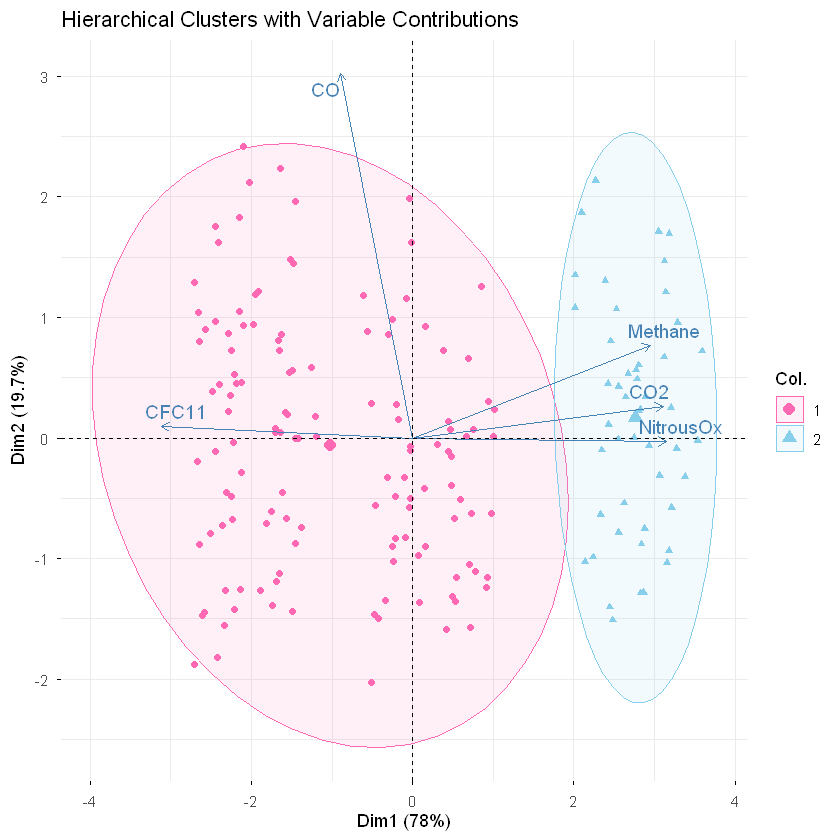

In [129]:
# Hierarchical Cluster Biplot 
fviz_pca_biplot(pca_result,  
                col.ind = factor(hc_clusters), 
                palette = c("#FF69B4", "#87CEEB"),   
                label = "var", 
                repel = TRUE, 
                addEllipses = TRUE, 
                ellipse.type = "norm", 
                title = "Hierarchical Clusters with Variable Contributions", 
                ggtheme = theme_minimal())

#### Interpretation

- The biplot shows distinct cluster centroids formed primarily along PC1 and PC2.

- Variables like CO₂, CO, and Methane dominate one side, while CFC-11 and Nitrous Oxide define the other, reflecting chemical behaviour divergence between clusters.

- This pattern suggests that certain gases co-vary strongly, driving cluster separation and potentially reflecting different pollution phases or atmospheric events.

### Final Summary

- Cleaned and imputed Mauna Loa atmospheric gas data (2000–2019), addressed missingness (MCAR/MAR), and performed PCA to retain key variance.
- Cluster analysis (K-Means, PAM, Hierarchical, Model-Based) revealed two stable clusters, with PAM performing best.
- Overall, the workflow builds a robust, end-to-end pipeline for uncovering meaningful atmospheric patterns.